In [3]:
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from scipy.stats import zscore
import svgutils.transform as sg
import plotly.express as px

mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42


## Loop through all the body parts - only amino acid conjugates - one figure

In [212]:
#import table Erin
df = pd.read_csv('.../All_ikoo_area_1_2024_11_11_16_54_24.txt', sep='\t')

#drop some columns
df = df.drop(columns=['Injection order ', 'Sample Name ', 'Sample Name .1'])

#concatenate tissue and time
df['tissue_time'] = df['Tissue Type '] + "_" + df['ZT'].astype(str)

#put as first column
df = df[[df.columns[-1]] + list(df.columns[:-1])]

#drop more columns
df = df.drop(columns=['Tissue Type ', 'ZT'])

#use groupby to have the average of compound in each time point for each organ
df = df.groupby('tissue_time').median().reset_index()

#create the tissue column and time
df['tissue'] = df['tissue_time'].str.split('_').str[0]
df['time'] = df['tissue_time'].str.split('_').str[1]

# Convert to ordered categorical
time_order = ['0', '4', '8', '12', '16', '20']
df['time'] = pd.Categorical(df['time'], categories=time_order, ordered=True)

#sort in the desired time order
df = df.sort_values(by=['tissue', 'time']).reset_index(drop=True)

#keep only the sample information and microbially-conjugated bile acids
microbial_ba = ['Ala-bMCA_17791','Ala-CA_17790','Arg-bMCA_23369','Arg-CA_23368','Arg-DCA_22370',
                'Asn-CA_20646','Gln-CA_21582','His-CA_22165','Ile-Leu-CA_20580','Ile-Leu-gMCA_20581',
                'Lys-bMCA_21589','Lys-CA_21586','Lys-CA_21588','Lys-gMCA_21590','Met-CA_21765',
                'Met-gMCA_21769','Ornithine-CA_20652','Phe-bMCA_22813','Phe-CA_22812','Ser-CA_18843',
                'Thr-CA_19755','Trp-bMCA_25122','Trp-CA_25121','Tyr-bMCA_23804','Tyr-CA_23803','Val-CA_19625']

columns_to_keep = ['tissue', 'time', 'tissue_time'] + microbial_ba

df = df[columns_to_keep]


In [227]:
### plot all clustermaps and organize in one file

output_dir = '.../clustermaps_per_organ'
os.makedirs(output_dir, exist_ok=True)

compound_cols = df.columns.difference(['tissue_time', 'tissue', 'time'])

svg_paths = []
titles = []

# Step 1: Save each clustermap as individual SVG
for bodypart in df['tissue'].unique():
    df_filtered = df[df['tissue'] == bodypart].copy()
    if df_filtered['time'].nunique() < 2:
        continue

    heatmap_data = df_filtered.set_index('time')[compound_cols].T
    heatmap_data = heatmap_data[(heatmap_data != 0).any(axis=1)]
    if heatmap_data.shape[0] == 0:
        continue

    heatmap_z = heatmap_data.apply(zscore, axis=1, result_type='broadcast')

    g = sns.clustermap(
        heatmap_z,
        metric='braycurtis',
        method='average',
        row_cluster=True,
        col_cluster=False,
        cmap='vlag',
        linewidths=0.1,
        linecolor='white',
        figsize=(4, 4),
        yticklabels=True
    )
    g.ax_heatmap.set_title(bodypart, fontsize=10)
    
    # Set font size for y-axis (compound) labels
    g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=6)

    # Set font size for x-axis (time) labels, if needed
    g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), fontsize=6)

    # Optionally adjust title font size too
    g.ax_heatmap.set_title(bodypart, fontsize=10)

    svg_path = os.path.join(output_dir, f"{bodypart.replace(' ', '_')}.svg")
    plt.savefig(svg_path, format='svg', bbox_inches='tight')
    plt.close()
    svg_paths.append(svg_path)
    titles.append(bodypart)

# Step 2: Combine all SVGs into a single SVG (vector layout)
n_cols = 4
n_rows = math.ceil(len(svg_paths) / n_cols)
fig_width = 200  # width in points
fig_height = 500  # height in points

combined = sg.SVGFigure(str(n_cols * fig_width), str(n_rows * fig_height))

panels = []
for idx, svg_file in enumerate(svg_paths):
    col = idx % n_cols
    row = idx // n_cols

    x_offset = col * fig_width
    y_offset = row * fig_height

    fig = sg.fromfile(svg_file)
    plot = fig.getroot()
    plot.moveto(x_offset, y_offset)
    panels.append(plot)

combined.append(panels)
final_svg_path = os.path.join(output_dir, "all_clustermaps_one_page.svg")
combined.save(final_svg_path)


# Big heatmaps for tissues and contents

### Contents

In [4]:
#import table Erin
df = pd.read_csv('.../All_ikoo_area_1_2024_11_11_16_54_24.txt', sep='\t')

#drop some columns
df = df.drop(columns=['Injection order ', 'Sample Name ', 'Sample Name .1'])

#concatenate tissue and time
df['tissue_time'] = df['Tissue Type '] + "_" + df['ZT'].astype(str)

#put as first column
df = df[[df.columns[-1]] + list(df.columns[:-1])]

#drop more columns
df = df.drop(columns=['Tissue Type ', 'ZT'])

#use groupby to have the average of compound in each time point for each organ
df = df.groupby('tissue_time').median().reset_index()

#create the tissue column and time
df['tissue'] = df['tissue_time'].str.split('_').str[0]
df['time'] = df['tissue_time'].str.split('_').str[1]

# Convert to ordered categorical
time_order = ['0', '4', '8', '12', '16', '20']
df['time'] = pd.Categorical(df['time'], categories=time_order, ordered=True)

#sort in the desired time order
df = df.sort_values(by=['tissue', 'time']).reset_index(drop=True)

#keep only the sample information and microbially-conjugated bile acids
microbial_ba = ['Ala-bMCA_17791','Ala-CA_17790','Arg-bMCA_23369','Arg-CA_23368','Arg-DCA_22370',
                'Asn-CA_20646','Gln-CA_21582','His-CA_22165','Ile-Leu-CA_20580','Ile-Leu-gMCA_20581',
                'Lys-bMCA_21589','Lys-CA_21586','Lys-CA_21588','Lys-gMCA_21590','Met-CA_21765',
                'Met-gMCA_21769','Ornithine-CA_20652','Phe-bMCA_22813','Phe-CA_22812','Ser-CA_18843',
                'Thr-CA_19755','Trp-bMCA_25122','Trp-CA_25121','Tyr-bMCA_23804','Tyr-CA_23803','Val-CA_19625']

columns_to_keep = ['tissue', 'time', 'tissue_time'] + microbial_ba

df = df[columns_to_keep]


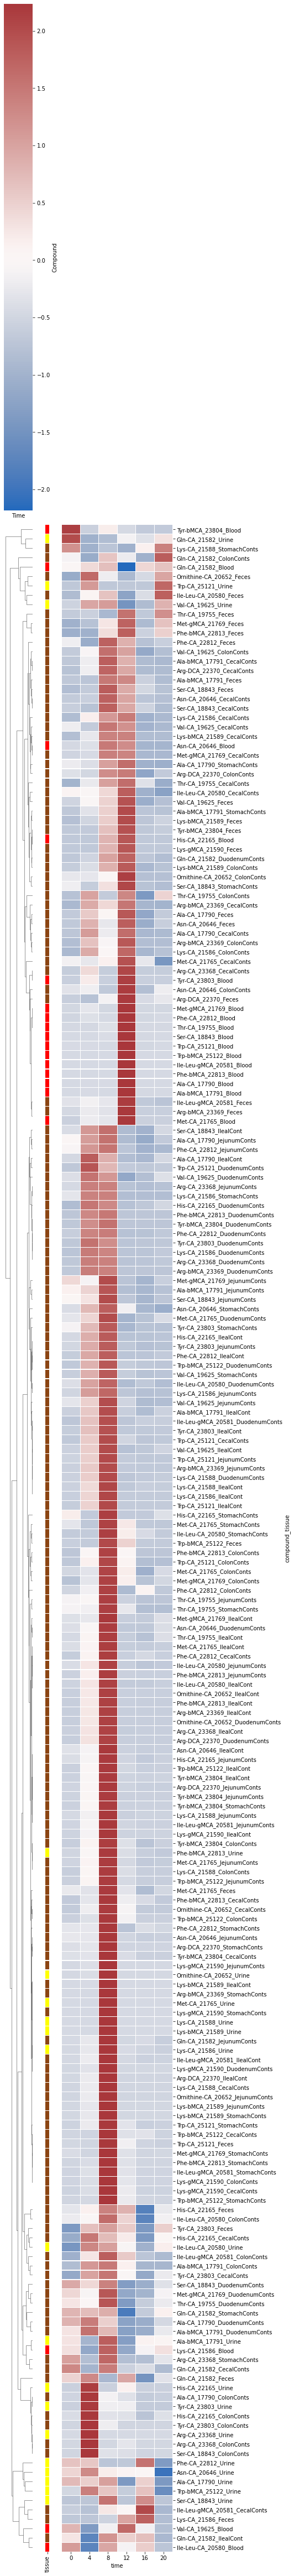

In [6]:
# Melt the dataframe to long format
df_melted = df.melt(id_vars=['tissue', 'time'], value_vars=microbial_ba,
                    var_name='compound', value_name='value')

#create a column compound_tissue
df_melted['compound_tissue'] = df_melted['compound'] + "_" + df_melted['tissue']

#keep only the contents
contents = ['CecalConts', 'ColonConts', 'DuodenumConts', 'IlealCont', 'JejunumConts', 'StomachConts', 
            'Blood', 'Urine', 'Feces']
df_melted = df_melted[df_melted['tissue'].isin(contents)]

# Pivot the data to shape it for the heatmap
heatmap_data = df_melted.pivot_table(index='compound_tissue', columns='time', values='value')

#remve compounds that are zero in all timepoints
heatmap_data = heatmap_data[(heatmap_data != 0).any(axis=1)]

#apply z-score normalization across each row (compound)
heatmap_z = heatmap_data.apply(zscore, axis=1, result_type='broadcast')

# Define tissue groups
red_group = ['Blood']
brown_group = ['CecalConts', 'ColonConts', 'DuodenumConts', 'IlealCont', 'JejunumConts', 'StomachConts', 'Feces']
yellow_group = ['Urine']

# Assign colors
tissue_colors_custom = {}

for tissue in df_melted['tissue'].unique():
    if tissue in red_group:
        tissue_colors_custom[tissue] = 'red'
    elif tissue in brown_group:
        tissue_colors_custom[tissue] = 'saddlebrown'
    else:
        tissue_colors_custom[tissue] = 'yellow'

# Extract tissue for each compound_tissue row
row_tissues = df_melted.drop_duplicates('compound_tissue').set_index('compound_tissue')['tissue']
row_colors = row_tissues.map(tissue_colors_custom).reindex(heatmap_z.index)

# Plot with annotation
sns.clustermap(
    heatmap_z,
    metric='braycurtis',
    row_cluster=True,
    col_cluster=False,
    cmap='vlag',
    linewidths=0.1,
    linecolor='white',
    figsize=(7.5, len(heatmap_z) * 0.3),
    row_colors=row_colors
)

plt.xlabel('Time')
plt.ylabel('Compound')
plt.tight_layout()
# plt.savefig('.../microbial_BAs_body_parts_ContentsOnly.pdf')
plt.show()



### Not contents

In [7]:
#import table Erin
df = pd.read_csv('.../All_ikoo_area_1_2024_11_11_16_54_24.txt', sep='\t')

#drop some columns
df = df.drop(columns=['Injection order ', 'Sample Name ', 'Sample Name .1'])

#concatenate tissue and time
df['tissue_time'] = df['Tissue Type '] + "_" + df['ZT'].astype(str)

#put as first column
df = df[[df.columns[-1]] + list(df.columns[:-1])]

#drop more columns
df = df.drop(columns=['Tissue Type ', 'ZT'])

#use groupby to have the average of compound in each time point for each organ
df = df.groupby('tissue_time').median().reset_index()

#create the tissue column and time
df['tissue'] = df['tissue_time'].str.split('_').str[0]
df['time'] = df['tissue_time'].str.split('_').str[1]

# Convert to ordered categorical
time_order = ['0', '4', '8', '12', '16', '20']
df['time'] = pd.Categorical(df['time'], categories=time_order, ordered=True)

#sort in the desired time order
df = df.sort_values(by=['tissue', 'time']).reset_index(drop=True)

#keep only the sample information and microbially-conjugated bile acids
microbial_ba = ['Ala-bMCA_17791','Ala-CA_17790','Arg-bMCA_23369','Arg-CA_23368','Arg-DCA_22370',
                'Asn-CA_20646','Gln-CA_21582','His-CA_22165','Ile-Leu-CA_20580','Ile-Leu-gMCA_20581',
                'Lys-bMCA_21589','Lys-CA_21586','Lys-CA_21588','Lys-gMCA_21590','Met-CA_21765',
                'Met-gMCA_21769','Ornithine-CA_20652','Phe-bMCA_22813','Phe-CA_22812','Ser-CA_18843',
                'Thr-CA_19755','Trp-bMCA_25122','Trp-CA_25121','Tyr-bMCA_23804','Tyr-CA_23803','Val-CA_19625']

columns_to_keep = ['tissue', 'time', 'tissue_time'] + microbial_ba

df = df[columns_to_keep]


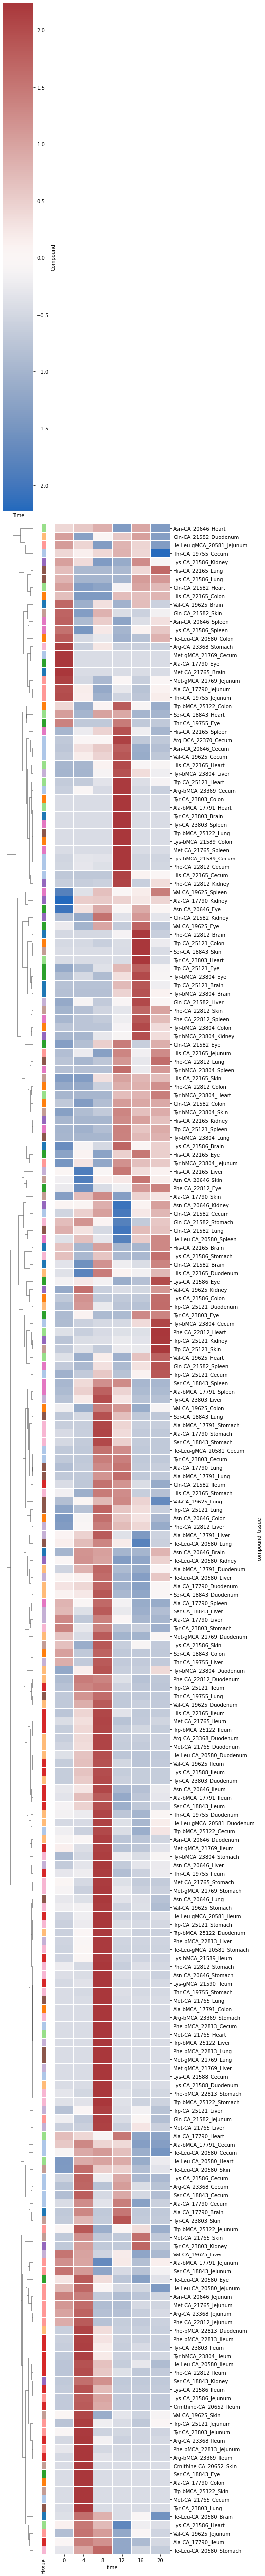

In [9]:
# Melt the dataframe to long format
df_melted = df.melt(id_vars=['tissue', 'time'], value_vars=microbial_ba,
                    var_name='compound', value_name='value')

#create a column compound_tissue
df_melted['compound_tissue'] = df_melted['compound'] + "_" + df_melted['tissue']

#keep only the other body parts except for contents
body_parts = ['Brain', 'Cecum', 'Colon', 'Duodenum', 'Eye', 'Heart', 'Ileum', 'Jejunum', 
              'Kidney', 'Liver', 'Lung', 'Skin', 'Spleen', 'Stomach']
df_melted = df_melted[df_melted['tissue'].isin(body_parts)]

# Pivot the data to shape it for the heatmap
heatmap_data = df_melted.pivot_table(index='compound_tissue', columns='time', values='value')

#remve compounds that are zero in all timepoints
heatmap_data = heatmap_data[(heatmap_data != 0).any(axis=1)]

#apply z-score normalization across each row (compound)
heatmap_z = heatmap_data.apply(zscore, axis=1, result_type='broadcast')

# Create a palette
palette = sns.color_palette('tab20', n_colors=len(body_parts))

# Map colors to tissue names
tissue_colors = dict(zip(body_parts, palette))

# Assign colors to compound_tissue rows
row_tissues = df_melted.drop_duplicates('compound_tissue').set_index('compound_tissue')['tissue']
row_colors = row_tissues.map(tissue_colors).reindex(heatmap_z.index)

# Plot with annotation
sns.clustermap(
    heatmap_z,
    metric='braycurtis',
    row_cluster=True,
    col_cluster=False,
    cmap='vlag',
    linewidths=0.1,
    linecolor='white',
    figsize=(7.5, len(heatmap_z) * 0.3),
    row_colors=row_colors
)

plt.xlabel('Time')
plt.ylabel('Compound')
plt.tight_layout()
# plt.savefig('.../microbial_BAs_body_parts_ContentsRemoved.pdf')
plt.show()
